In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
nifti_dirs = [
    'MRE_DICOM_7-31-19',
    'MRE_DICOM_9-12-19',
    'MRE_DICOM_10-09-19',
    'MRE_DICOM_10-22-19'
]

sequences = [
    'dwi',
    'mre',
    'mre_mask',
    'mre_raw',
    'mre_wave',
    'mre_phase',
    #'t1_pos_0_fat',
    #'t1_pos_0_in',
    #'t1_pos_0_out',
    #'t1_pos_0_water',
    #'t1_pos_160_fat',
    #'t1_pos_160_in',
    #'t1_pos_160_out',
    #'t1_pos_160_water',
    #'t1_pos_300_fat',
    #'t1_pos_300_in',
    #'t1_pos_300_out',
    #'t1_pos_300_water',
    #'t1_pos_70_fat',
    #'t1_pos_70_in',
    #'t1_pos_70_out',
    #'t1_pos_70_water',
    #'t1_pre_fat',
    #'t1_pre_in',
    #'t1_pre_out',
    't1_pre_water',
    #'t2',
    'wave'
]

def load_nifti_metadata(nii_file):
    image = sitk.ReadImage(nii_file)
    dim = image.GetDimension()
    size = image.GetSize()
    origin = image.GetOrigin()
    spacing = image.GetSpacing()
    components = image.GetNumberOfComponentsPerPixel()
    type_ = image.GetPixelIDTypeAsString()
    return image, dim, size, origin, spacing, components, type_

import pandas as pd
index_cols = ['nifti_dir', 'patient_id', 'sequence']
df = pd.DataFrame(columns=index_cols).set_index(index_cols)

for nifti_dir in nifti_dirs[:1]:
    print(nifti_dir)
    nifti_dir = os.path.join(data_root, nifti_dir, 'NIFTI')
    patient_ids = sorted(os.listdir(nifti_dir))
    n_patient_ids = len(patient_ids)
    for i, patient_id in enumerate(patient_ids):
        print(f'  [{i+1} / {n_patient_ids}] {patient_id}')
        patient_dir = os.path.join(nifti_dir, patient_id)
        for nii_base in os.listdir(patient_dir):
            if not nii_base.endswith('.nii'):
                continue
            seq = os.path.splitext(nii_base)[0]
            idx = (nifti_dir, patient_id, seq)
            nii_file = os.path.join(nifti_dir, patient_id, nii_base)
            image = sitk.ReadImage(nii_file)
            df.loc[idx, 'dimension'] = image.GetDimension()
            df.loc[idx, 'size'] = str(image.GetSize())
            df.loc[idx, 'origin'] = str(image.GetOrigin())
            df.loc[idx, 'spacing'] = str(image.GetSpacing())
            df.loc[idx, 'components'] = image.GetNumberOfComponentsPerPixel()
            df.loc[idx, 'type'] = image.GetPixelIDTypeAsString()

df

In [ ]:
df.groupby('sequence').nunique()

In [ ]:
df.loc[:,:,['t1_pre_water','mre', 'wave']].groupby(['sequence', 'size']).count()

## Data processing steps

- load SITK images from NIFIT files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [4]:
%autoreload
patient = mre_pinn.data.MREPatient(
    data_root='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=['t1_pre_water', 't1_pre_in', 't1_pre_out', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre']
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [5]:
patient.describe()

,dtype,count,mean,std,min,25%,50%,75%,max
sequence,,,,,,,,,
t1_pre_water,int16,23068672,111.629415,170.288701,0.0,14.0,29.0,157.0,3195.0
t1_pre_in,int16,23068672,256.329780,336.797345,0.0,28.0,66.0,397.0,3907.0
t1_pre_out,int16,23068672,213.906748,298.879722,0.0,28.0,66.0,309.0,3524.0
t1_pre_fat,int16,23068672,174.047992,356.770369,0.0,15.0,28.0,124.0,4692.0
t2,int16,1507328,99.084073,139.547549,0.0,0.0,17.0,162.0,1048.0
mre_raw,int16,262144,46.776093,60.531542,0.0,1.0,19.0,77.0,562.0
wave,uint8,3145728,28.437843,64.585620,0.0,0.0,0.0,15.0,255.0
mre,int16,262144,1505.871937,1335.735833,0.0,0.0,1340.0,2212.0,14078.0


In [6]:
%autoreload
patient.preprocess_images(register=True, segment=False)

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_water to mre_raw
Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 5 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0, 0, 0, 0]
Scales are estimated automatically.
Scales for transform parameters are: [

122	-0.621116	4.866646	26.555487	0.006201	3.7
123	-0.623121	4.599536	26.832571	0.005424	2.2
124	-0.642299	4.332289	27.115646	0.006658	2.2
125	-0.639023	4.065042	27.404757	0.003173	1.9
126	-0.642098	4.903162	26.518051	0.006484	2.0
127	-0.641194	4.654651	26.774927	0.004849	2.0
128	-0.643136	4.389342	27.054714	0.003926	1.9
129	-0.643058	4.122097	27.342517	0.004522	2.3
130	-0.649005	3.855036	27.636306	0.004933	2.1
131	-0.653375	3.587794	27.936682	0.004156	2.0
132	-0.654702	3.320892	28.243264	0.005601	2.2
133	-0.642379	3.116939	28.482113	0.004515	2.0
134	-0.635854	2.849693	28.801267	0.007968	2.0
135	-0.650129	3.849693	27.642249	0.004130	1.9
136	-0.645535	3.582447	27.942759	0.006454	1.8
137	-0.632605	3.315205	28.249871	0.006869	1.8
138	-0.636759	3.047958	28.563814	0.002315	2.2
139	-0.638186	2.780892	28.884593	0.005574	2.1
140	-0.624232	2.582501	29.127588	0.004353	2.0
141	-0.648256	2.315255	29.461457	0.007947	2.0
142	-0.632202	3.315245	28.249824	0.007193	2.2
143	-0.645136	3.047998	28.563766	0

28	-0.552144	1.569385	18.114591	0.005690	2.9
29	-0.538845	0.917496	18.653371	0.007486	2.0
30	-0.509299	0.234830	19.253047	0.008592	2.0
31	-0.528325	0.000000	19.468342	0.008369	2.0
32	-0.520442	0.000000	19.468342	0.008589	2.0
33	-0.529592	0.993062	18.589280	0.015070	2.0
34	-0.525265	1.993062	17.780807	0.004776	2.0
35	-0.515241	1.287321	18.343846	0.004463	2.0
36	-0.519190	1.210683	18.407141	0.014578	2.0
37	-0.510951	0.504854	19.011298	0.003387	1.9
38	-0.526790	1.441557	18.217773	0.006225	1.9
39	-0.547931	0.745482	18.800926	0.006416	2.1
40	-0.513942	0.885333	18.680784	0.008526	2.1
41	-0.512093	0.179576	19.303275	0.006360	2.1
42	-0.522340	0.000000	19.468342	0.006564	2.0
43	-0.546825	0.000000	19.468342	0.006871	2.0
44	-0.561929	0.000000	19.468342	0.006040	2.0
45	-0.530397	0.000000	19.468342	0.011702	2.0
46	-0.535003	0.000000	19.468342	0.012890	1.8
47	-0.526775	0.000000	19.468342	0.006157	1.9
48	-0.537490	0.962935	18.614779	0.009395	1.9
49	-0.519976	0.260983	19.229365	0.016624	1.9
50	-0.5052

234	-0.519599	9.306634	13.489957	0.007598	3.7
235	-0.537977	10.306547	13.059095	0.004542	2.2
236	-0.523896	11.162879	12.711399	0.009500	2.0
237	-0.529693	10.531403	12.965969	0.008526	2.0
238	-0.517522	10.346934	13.042270	0.005060	2.0
239	-0.520058	9.721593	13.307747	0.009801	1.9
240	-0.542783	9.015923	13.620610	0.005766	1.9
241	-0.559221	10.013654	13.182426	0.006876	2.2
242	-0.529501	9.930099	13.218037	0.007826	2.0
243	-0.551105	10.927368	12.805164	0.010576	2.1
244	-0.523832	10.978052	12.784868	0.004615	2.0
245	-0.529551	10.312515	13.056606	0.005893	1.8
246	-0.531517	9.616094	13.353604	0.008822	2.2
247	-0.555850	10.613928	12.932122	0.008873	2.1
248	-0.512556	11.613928	12.535601	0.002553	1.9
249	-0.548260	12.403368	12.239340	0.005668	1.8
250	-0.540718	12.824204	12.087060	0.009422	1.8
251	-0.534114	12.119087	12.344398	0.003343	1.9
252	-0.513707	12.562320	12.181374	0.005482	2.0
253	-0.541276	12.752961	12.112572	0.005106	1.7
254	-0.555187	13.704597	11.780433	0.012946	1.8
255	-0.532837	12.9

147	-0.415146	17.910107	6.224590	0.005314	2.5
148	-0.394101	18.687000	6.102741	0.005796	2.0
149	-0.424988	18.203058	6.178076	0.008739	2.0
150	-0.410919	18.451807	6.139122	0.011375	1.9
151	-0.428084	19.451802	5.987359	0.003872	1.9
152	-0.406705	20.315450	5.862201	0.004728	1.9
153	-0.407489	20.328924	5.860290	0.006490	1.9
154	-0.432268	19.800199	5.936233	0.005873	1.9
155	-0.412787	18.995483	6.055671	0.002981	1.9
156	-0.415115	19.380226	5.997972	0.010094	2.0
157	-0.443597	19.898303	5.921993	0.014332	1.8
158	-0.430100	20.898301	5.780651	0.008053	1.8
159	-0.407269	20.039663	5.901595	0.006512	1.9
160	-0.415532	19.182649	6.027464	0.007062	1.8
161	-0.428503	18.328011	6.158447	0.008783	1.8
162	-0.417392	17.480111	6.294147	0.009801	2.1
163	-0.413722	16.797589	6.407802	0.004132	1.7
164	-0.398724	15.970112	6.551224	0.006943	2.1
165	-0.421392	15.186369	6.693114	0.011762	2.1
166	-0.410202	14.334865	6.854405	0.008093	1.9
167	-0.427611	13.476242	7.025112	0.008700	2.1
168	-0.425741	14.437089	6.834632	0

62	-0.356547	5.185083	12.422822	0.011100	3.0
63	-0.353298	6.124643	11.992513	0.012519	2.0
64	-0.355730	5.337675	12.350848	0.006678	2.2
65	-0.350809	4.550707	12.731257	0.009914	2.0
66	-0.344975	4.242009	12.886955	0.007989	2.2
67	-0.373992	4.833379	12.591951	0.005713	2.0
68	-0.371725	5.827915	12.125155	0.003909	2.1
69	-0.357420	5.471290	12.288507	0.013382	1.9
70	-0.368331	4.756163	12.629701	0.002073	1.9
71	-0.351789	3.991377	13.016195	0.003134	1.9
72	-0.351369	3.686644	13.176867	0.016315	2.1
73	-0.364177	2.900453	13.610312	0.008211	1.8
74	-0.353081	3.900453	13.063723	0.010465	1.9
75	-0.346262	4.900452	12.559342	0.006054	2.0
76	-0.371977	5.899055	12.093087	0.010947	2.1
77	-0.363590	6.899028	11.659640	0.007189	2.0
78	-0.327826	6.114053	11.997197	0.014876	1.9
79	-0.364262	5.327088	12.355815	0.015390	1.8
80	-0.341737	4.540120	12.736535	0.004678	1.8
81	-0.341296	3.753561	13.141246	0.004381	1.9
82	-0.368959	4.625935	12.693883	0.010399	1.9
83	-0.354839	4.055118	12.983081	0.007295	1.9
84	-0.3671


Final metric value  = -0.343770
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 686.901385 408.835183 242.199473 325.292626 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.267247 -0.705831 -0.858665 -0.786968 )
( SigmoidScale 0.000001 0.000004 0.000006 0.000005 )

Time spent on saving the results, applying the final transform etc.: 3970 ms.
Registering t1_pre_in to mre_raw
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading im

64	-0.714733	0.000000	18.098428	0.010233	3.8
65	-0.736991	0.000000	18.098428	0.012617	2.0
66	-0.735580	0.000000	18.098428	0.009423	2.1
67	-0.743168	0.000000	18.098428	0.011449	2.1
68	-0.754298	0.000000	18.098428	0.011349	2.1
69	-0.750716	0.000000	18.098428	0.011015	1.9
70	-0.750217	0.000000	18.098428	0.010988	2.2
71	-0.753174	0.000000	18.098428	0.008356	2.0
72	-0.730969	0.000000	18.098428	0.010380	2.1
73	-0.709996	0.000000	18.098428	0.009212	2.0
74	-0.754528	0.000000	18.098428	0.009199	2.1
75	-0.762901	0.000000	18.098428	0.010685	2.1
76	-0.728761	0.000000	18.098428	0.009389	2.3
77	-0.738076	0.000000	18.098428	0.010443	2.0
78	-0.758555	0.000000	18.098428	0.009175	2.1
79	-0.746068	0.000000	18.098428	0.008817	2.2
80	-0.702170	0.000000	18.098428	0.008715	2.1
81	-0.738842	0.000000	18.098428	0.010257	2.2
82	-0.749906	0.000000	18.098428	0.012288	2.0
83	-0.757302	0.000000	18.098428	0.010284	2.0
84	-0.760307	0.000000	18.098428	0.008996	2.0
85	-0.779944	0.000000	18.098428	0.007976	2.0
86	-0.7429

  Computing the moving image extrema took 40 ms.
Initialization of AdvancedMattesMutualInformation metric took: 41 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001406s
  NumberOfGradientMeasurements to estimate sigma_i: 6
  Sampling gradients ...
  Sampling the gradients took 0.025641s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.697348	0.000000	24.439301	0.005410	70.5
1	-0.737115	0.000000	24.439301	0.008237	2.1
2	-0.719752	0.000000	24.439301	0.015477	2.0
3	-0.725180	0.825113	23.515357	0.004931	2.0
4	-0.713519	1.824954	22.485273	0.007718	2.0
5	-0.685186	1.893383	22.418064	0.006251	2.1
6	-0.713627	1.525873	22.783815	0.003843	2.3
7	-0.735613	1.158935	23.161101	0.011276	2.2
8	-0.714203	1.294093	23.020686	0.006243	2.0
9	-0.717697	0.926583	23.406534	0.006060	2.0
10	-0.696882	

180	-0.710169	29.024766	10.259425	0.007925	2.1
181	-0.759138	28.730877	10.320054	0.007090	2.8
182	-0.734764	28.363368	10.396886	0.002998	2.1
183	-0.705661	29.305647	10.202141	0.005438	2.1
184	-0.728015	29.857430	10.091452	0.008165	1.9
185	-0.717292	30.857269	9.896883	0.011047	2.0
186	-0.713977	30.494163	9.966670	0.005241	2.1
187	-0.730619	30.126653	10.038312	0.003996	2.1
188	-0.724134	29.872703	10.088423	0.007530	2.2
189	-0.719781	30.271231	10.010006	0.008038	2.3
190	-0.716269	31.271231	9.818505	0.006374	2.1
191	-0.750271	32.271224	9.634194	0.009895	2.1
192	-0.720151	31.903715	9.701121	0.001965	2.2
193	-0.732356	31.777666	9.724290	0.002458	2.0
194	-0.710312	32.101385	9.665008	0.003013	2.1
195	-0.724806	32.446583	9.602584	0.008394	2.1
196	-0.735894	32.223466	9.642839	0.006106	2.0
197	-0.732360	33.223462	9.465005	0.009540	2.0
198	-0.721271	34.223146	9.293663	0.005060	2.3
199	-0.723005	33.863875	9.354522	0.008463	2.0
200	-0.730937	34.607707	9.229392	0.005752	2.0
201	-0.748772	34.240208	9.

  Computing the Jacobian terms took 0.001452s
  NumberOfGradientMeasurements to estimate sigma_i: 6
  Sampling gradients ...
  Sampling the gradients took 0.025558s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.690994	0.000000	22.012460	0.009381	71.1
1	-0.664977	0.000000	22.012460	0.005018	2.0
2	-0.683958	0.000000	22.012460	0.013938	2.0
3	-0.665272	0.999981	21.011911	0.011237	2.0
4	-0.658627	0.556133	21.444554	0.007435	2.1
5	-0.659739	1.556133	20.493835	0.006365	2.2
6	-0.697821	1.117551	20.900218	0.006557	2.2
7	-0.667060	0.699147	21.303218	0.004781	2.2
8	-0.674074	1.686650	20.375933	0.004497	2.1
9	-0.681189	1.250498	20.775339	0.003744	2.1
10	-0.640503	0.834563	21.171097	0.010402	2.1
11	-0.674193	1.060597	20.954177	0.003699	2.1
12	-0.669212	0.648404	21.353152	0.008800	2.1
13	-0.655829	0.221885	21.782308	0.013598	2.1
14	-0.668295	1.221885	20.802090	0.005159	2.0
15	-0.681752	0.778011	21.226073	0.006823	2.3
16	-0.662392	1.409448	

181	-0.656345	44.688599	7.037167	0.007444	3.7
182	-0.671033	44.245822	7.084923	0.008236	2.1
183	-0.695085	45.244038	6.978162	0.008134	2.0
184	-0.672628	44.800191	7.025233	0.006103	1.9
185	-0.675991	44.356579	7.072917	0.006395	1.9
186	-0.688316	45.275262	6.974875	0.006953	2.0
187	-0.680395	44.834886	7.021530	0.008177	2.0
188	-0.689099	45.834852	6.916476	0.009455	2.2
189	-0.680189	45.390975	6.962718	0.010518	2.0
190	-0.673524	44.953548	7.008897	0.004585	2.1
191	-0.698054	45.953491	6.904220	0.012271	2.1
192	-0.617947	45.513661	6.949875	0.004353	2.1
193	-0.644040	46.276848	6.871036	0.006612	2.0
194	-0.658577	47.044227	6.793547	0.008150	2.0
195	-0.662187	46.600425	6.838147	0.005167	2.0
196	-0.685830	46.156594	6.883340	0.006525	2.0
197	-0.675259	46.995646	6.798401	0.005087	2.0
198	-0.678366	46.552432	6.843005	0.006976	2.0
199	-0.700553	47.443584	6.753908	0.003867	2.0
200	-0.676210	47.014242	6.796542	0.009918	2.0
201	-0.680451	46.570570	6.841168	0.005882	2.0
202	-0.667478	46.353082	6.863259	0

83	-0.630716	8.000500	10.119292	0.003910	3.0
84	-0.631486	8.967429	9.792783	0.007225	2.0
85	-0.602341	9.897329	9.498054	0.009843	2.1
86	-0.623815	9.053417	9.764764	0.002706	1.9
87	-0.612592	8.230488	10.039672	0.006456	1.8
88	-0.627418	7.470257	10.307758	0.002465	2.1
89	-0.643735	6.684752	10.600222	0.008345	2.0
90	-0.604527	7.326951	10.359905	0.005850	2.0
91	-0.619573	8.315508	10.010556	0.007281	2.0
92	-0.632530	9.314853	9.680552	0.006933	2.2
93	-0.657185	9.156534	9.731374	0.004205	2.3
94	-0.635686	8.519328	9.941436	0.003798	2.0
95	-0.595378	8.869396	9.824923	0.010811	2.0
96	-0.618050	9.588487	9.593953	0.004440	2.1
97	-0.620975	8.755510	9.862527	0.004271	1.9
98	-0.606517	9.417550	9.647868	0.006970	2.0
99	-0.601213	8.617293	9.908553	0.001963	2.1
100	-0.633343	8.837946	9.835279	0.002086	2.1
101	-0.618434	8.673706	9.889716	0.011325	2.2
102	-0.622803	7.995057	10.121191	0.006203	2.2
103	-0.619750	7.512852	10.292359	0.003358	2.0
104	-0.612326	7.827648	10.179967	0.005074	2.3
105	-0.629868	7.24


Final metric value  = -0.609471
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 380.066994 513.225321 462.261651 293.464519 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.162446 -0.367510 -0.443877 -0.844082 )
( SigmoidScale 0.000003 0.000003 0.000004 0.000005 )

Time spent on saving the results, applying the final transform etc.: 3985 ms.
Registering t1_pre_out to mre_raw
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading i

62	-0.717865	0.000000	18.968658	0.010818	3.3
63	-0.727561	0.000000	18.968658	0.010689	1.8
64	-0.698023	0.000000	18.968658	0.011153	1.9
65	-0.731085	0.000000	18.968658	0.011551	1.9
66	-0.718851	0.000000	18.968658	0.010050	2.1
67	-0.735988	0.000000	18.968658	0.015828	2.0
68	-0.743776	0.000000	18.968658	0.010083	2.3
69	-0.739253	0.000000	18.968658	0.009861	2.0
70	-0.742791	0.000000	18.968658	0.011084	2.0
71	-0.743191	0.000000	18.968658	0.009213	2.0
72	-0.721262	0.000000	18.968658	0.010220	2.0
73	-0.701369	0.000000	18.968658	0.009183	1.9
74	-0.744588	0.000000	18.968658	0.010229	2.0
75	-0.751638	0.000000	18.968658	0.012241	2.0
76	-0.715122	0.000000	18.968658	0.010644	2.0
77	-0.727477	0.000000	18.968658	0.010050	1.9
78	-0.754754	0.000000	18.968658	0.009265	2.1
79	-0.738491	0.000000	18.968658	0.009584	1.8
80	-0.699633	0.000000	18.968658	0.009444	1.9
81	-0.729086	0.000000	18.968658	0.012251	1.9
82	-0.740677	0.000000	18.968658	0.010793	2.0
83	-0.746291	0.000000	18.968658	0.010176	1.9
84	-0.7562

  Computing the moving image extrema took 41 ms.
Initialization of AdvancedMattesMutualInformation metric took: 43 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001404s
  NumberOfGradientMeasurements to estimate sigma_i: 6
  Sampling gradients ...
  Sampling the gradients took 0.025689s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.680196	0.000000	25.542326	0.006160	72.4
1	-0.725902	0.000000	25.542326	0.008246	2.1
2	-0.713658	0.963087	24.422288	0.011364	2.0
3	-0.721257	0.520759	24.924253	0.005450	2.0
4	-0.711849	0.078540	25.447154	0.008172	1.9
5	-0.670101	0.000000	25.542326	0.007071	2.1
6	-0.706287	0.000000	25.542326	0.007535	2.1
7	-0.718521	0.983587	24.399514	0.005026	1.9
8	-0.711768	1.982297	23.339218	0.006249	2.1
9	-0.716749	1.557522	23.778713	0.005571	2.1
10	-0.687484	

190	-0.703650	45.115091	8.112956	0.007640	2.7
191	-0.730092	46.115091	7.992075	0.005739	2.0
192	-0.708918	45.672789	8.045094	0.008433	2.0
193	-0.728513	45.230470	8.098823	0.003308	1.9
194	-0.697473	46.208062	7.981019	0.007815	1.9
195	-0.704292	47.207192	7.864110	0.010236	1.8
196	-0.720725	48.207192	7.750478	0.009522	2.0
197	-0.721230	49.207192	7.640084	0.002806	2.1
198	-0.711372	48.980123	7.664874	0.005104	2.0
199	-0.705376	49.537750	7.604281	0.007749	2.1
200	-0.721849	50.537675	7.497991	0.010711	2.0
201	-0.731061	51.402603	7.408419	0.003950	2.0
202	-0.714808	52.393437	7.308403	0.002934	2.1
203	-0.706435	52.088538	7.338891	0.006635	2.0
204	-0.719950	53.029501	7.245609	0.004090	1.9
205	-0.719440	53.999787	7.151872	0.008871	1.9
206	-0.726638	53.557753	7.194273	0.012177	1.9
207	-0.721326	53.115425	7.237209	0.007318	2.0
208	-0.722146	54.115425	7.140861	0.014245	1.9
209	-0.703847	53.673097	7.183161	0.006186	2.0
210	-0.708131	53.230768	7.225964	0.002517	1.9
211	-0.715793	54.144803	7.138070	0

2	-0.654769	0.000000	16.660541	0.005819	3.3
3	-0.635548	0.708785	16.116580	0.010444	2.0
4	-0.627812	0.137366	16.552269	0.003627	2.1
5	-0.631424	0.218008	16.489359	0.002495	2.1
6	-0.668530	0.154142	16.539142	0.006509	2.0
7	-0.634140	0.528397	16.251622	0.007663	2.1
8	-0.640595	0.000000	16.660541	0.007409	2.0
9	-0.645825	0.000000	16.660541	0.009559	2.2
10	-0.614885	0.000000	16.660541	0.009248	2.2
11	-0.645857	0.973894	15.922137	0.008092	2.1
12	-0.636803	0.401807	16.347749	0.006813	2.0
13	-0.616033	0.000000	16.660541	0.008462	2.2
14	-0.637725	0.981952	15.916301	0.010375	2.0
15	-0.665876	0.423383	16.331285	0.008218	2.2
16	-0.640138	0.000000	16.660541	0.013495	2.0
17	-0.648408	0.999999	15.903245	0.007802	2.0
18	-0.649493	0.888580	15.984196	0.011028	2.1
19	-0.619116	0.316346	16.413289	0.006278	2.0
20	-0.652280	1.313077	15.680104	0.004505	2.0
21	-0.637043	0.797308	16.051127	0.014115	2.1
22	-0.619846	0.301930	16.424397	0.004636	2.0
23	-0.638037	0.000000	16.660541	0.008412	2.0
24	-0.620962	0.453

200	-0.645718	27.463325	7.219302	0.004740	3.6
201	-0.652376	26.893858	7.305141	0.003130	2.1
202	-0.638464	27.479704	7.216863	0.006639	2.0
203	-0.638060	27.765373	7.174586	0.003242	2.0
204	-0.641347	28.152436	7.118088	0.004162	2.0
205	-0.636947	27.780225	7.172402	0.006134	2.1
206	-0.672167	27.359517	7.234799	0.016566	2.0
207	-0.628570	26.787317	7.321427	0.004414	2.1
208	-0.642958	27.787249	7.171369	0.011848	2.1
209	-0.634402	27.229322	7.254329	0.005520	2.0
210	-0.645735	28.138185	7.120152	0.013377	2.2
211	-0.638104	27.566029	7.204035	0.007294	2.2
212	-0.633233	28.565961	7.058702	0.006302	2.0
213	-0.623652	27.996164	7.140791	0.008991	1.9
214	-0.635882	28.981312	7.000043	0.005204	1.9
215	-0.638119	29.977543	6.863245	0.005625	2.0
216	-0.671195	30.193190	6.834334	0.008735	2.0
217	-0.666604	29.634171	6.909787	0.016612	2.0
218	-0.679759	29.061928	6.988771	0.007792	2.1
219	-0.649262	28.489685	7.069581	0.015065	1.9
220	-0.628161	29.489685	6.929561	0.011463	2.0
221	-0.658272	28.917442	7.009000	0

109	-0.573820	21.341946	4.656387	0.004296	3.6
110	-0.556249	21.592268	4.629021	0.010983	1.9
111	-0.565623	22.266512	4.556884	0.007229	2.1
112	-0.573124	23.107536	4.469996	0.004710	2.0
113	-0.573702	22.966623	4.484322	0.004470	2.0
114	-0.570281	23.315156	4.449053	0.005687	1.9
115	-0.541204	23.680225	4.412701	0.012873	2.1
116	-0.572421	23.178477	4.462818	0.011889	2.0
117	-0.587513	23.295189	4.451059	0.019539	2.1
118	-0.581228	24.291145	4.353180	0.009228	2.0
119	-0.564053	25.096474	4.277127	0.006709	2.0
120	-0.599956	25.967465	4.197810	0.024642	1.9
121	-0.582978	26.918781	4.114472	0.007583	2.1
122	-0.582790	27.862175	4.035033	0.005186	2.1
123	-0.579376	28.128087	4.013193	0.013657	2.0
124	-0.586638	28.058411	4.018893	0.016842	2.1
125	-0.576600	29.058120	3.938631	0.005950	1.9
126	-0.577031	28.435713	3.988220	0.013477	1.9
127	-0.555145	28.916914	3.949773	0.004961	2.0
128	-0.592143	28.446473	3.987352	0.003745	2.0
129	-0.594875	28.246141	4.003572	0.004990	2.0
130	-0.567474	28.263648	4.002150	0

Preparation of the image pyramids took: 4311 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this value.
  You may select the RandomSparseMask image sampler to fix

162	-0.337106	12.577428	19.420379	0.002335	2.8
163	-0.360996	12.994413	19.182163	0.009310	1.9
164	-0.342268	12.743234	19.324952	0.003509	2.1
165	-0.353029	12.491983	19.469924	0.006080	2.0
166	-0.331271	12.240741	19.617083	0.003964	2.1
167	-0.360339	13.209116	19.061772	0.007923	2.0
168	-0.368626	14.206409	18.521809	0.007511	1.9
169	-0.351197	15.206409	18.010247	0.005063	1.9
170	-0.340774	14.955165	18.136097	0.003333	2.1
171	-0.342061	14.710810	18.260196	0.003758	1.9
172	-0.348134	14.468463	18.384963	0.004532	2.0
173	-0.338124	14.217233	18.516116	0.005181	2.0
174	-0.347860	15.198373	18.014245	0.005377	1.9
175	-0.360512	16.198345	17.529984	0.002659	2.0
176	-0.347131	16.024028	17.612518	0.003361	1.8
177	-0.369494	15.775729	17.731433	0.008948	2.0
178	-0.332534	15.524493	17.853400	0.007297	2.0
179	-0.359901	15.273242	17.977063	0.006290	2.0
180	-0.328482	15.021992	18.102452	0.003915	1.8
181	-0.374280	15.987808	17.629765	0.005822	2.0
182	-0.374039	16.976474	17.170798	0.004396	2.0
183	-0.360675

  Computing the moving image extrema took 43 ms.
Initialization of AdvancedMattesMutualInformation metric took: 44 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001368s
  NumberOfGradientMeasurements to estimate sigma_i: 6
  Sampling gradients ...
  Sampling the gradients took 0.025529s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.297994	0.000000	20.853669	0.007890	73.4
1	-0.306145	0.000000	20.853669	0.007252	2.1
2	-0.312048	0.999966	19.905805	0.009173	2.2
3	-0.341853	1.999966	19.040334	0.005711	2.2
4	-0.319857	1.693321	19.297618	0.002352	2.1
5	-0.284188	0.949820	19.951282	0.002841	2.2
6	-0.290268	0.448069	20.418018	0.002902	2.1
7	-0.313709	0.000000	20.853669	0.003536	2.3
8	-0.312051	0.000000	20.853669	0.005322	2.0
9	-0.323469	0.000000	20.853669	0.003858	2.2
10	-0.289717	

185	-0.289815	19.396699	10.840664	0.001770	3.7
186	-0.281951	18.832251	10.994283	0.003233	1.9
187	-0.321483	18.853491	10.988424	0.004639	1.8
188	-0.317983	18.089057	11.203316	0.003555	1.8
189	-0.314140	18.184357	11.176068	0.005461	1.8
190	-0.324662	18.608546	11.056378	0.005965	1.9
191	-0.330032	19.584364	10.790536	0.007449	2.0
192	-0.296836	18.815192	10.998994	0.005912	1.9
193	-0.321834	19.815172	10.729516	0.004032	1.8
194	-0.296192	19.088103	10.924115	0.003184	2.0
195	-0.327222	19.905501	10.705823	0.006721	1.9
196	-0.337128	19.467871	10.821598	0.001998	1.9
197	-0.313280	19.013661	10.944438	0.006739	2.0
198	-0.317123	18.469580	11.095305	0.003990	2.1
199	-0.306949	17.687087	11.319721	0.003803	2.0
200	-0.317915	16.934395	11.544327	0.010346	2.0
201	-0.321902	17.932669	11.248318	0.010217	2.1
202	-0.322543	18.932669	10.966636	0.003625	2.0
203	-0.312812	19.865937	10.716188	0.004457	2.0
204	-0.331149	20.409683	10.575474	0.012810	2.1
205	-0.322352	19.626962	10.779222	0.010751	2.0
206	-0.317850

  Sampling the gradients took 0.027158s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.320615	0.000000	15.755703	0.009441	74.1
1	-0.296309	0.000000	15.755703	0.008883	2.1
2	-0.310162	0.000000	15.755703	0.024530	2.0
3	-0.259145	0.951913	15.072480	0.006314	2.1
4	-0.273176	0.174751	15.625675	0.010175	2.1
5	-0.289807	0.959645	15.067173	0.009036	2.0
6	-0.297923	0.182495	15.619962	0.008206	2.1
7	-0.283850	0.000000	15.755703	0.009989	2.1
8	-0.299410	0.000000	15.755703	0.005440	2.1
9	-0.291270	0.000000	15.755703	0.006912	2.1
10	-0.276761	0.617868	15.305384	0.013390	2.0
11	-0.284295	0.086890	15.690781	0.006940	2.0
12	-0.289393	1.086886	14.980372	0.001595	2.0
13	-0.267647	0.950926	15.073158	0.008815	2.2
14	-0.275928	0.630274	15.296606	0.005142	1.9
15	-0.301495	0.098297	15.682297	0.009625	2.1
16	-0.288118	0.000000	15.755703	0.002831	2.2
17	-0.289080	0.000000	15.755703	0.006752	2.0
18	-0.298690	0.000000	15.755703	0.007372	2.0
19	-0.278667

197	-0.285667	11.523130	10.173368	0.005994	3.7
198	-0.311673	12.523030	9.869924	0.003486	2.0
199	-0.300070	11.871792	10.065462	0.007418	2.2
200	-0.289783	12.106448	9.994118	0.007025	2.0
201	-0.293730	11.931616	10.047177	0.003702	1.9
202	-0.267904	11.811756	10.083879	0.012752	1.9
203	-0.266646	11.160423	10.288104	0.005473	1.9
204	-0.286763	12.156083	9.979157	0.015729	1.9
205	-0.297056	13.155705	9.687101	0.007819	1.9
206	-0.301299	14.155705	9.411553	0.002893	2.0
207	-0.272979	13.708625	9.532782	0.015933	2.2
208	-0.294922	12.933030	9.750670	0.005376	2.1
209	-0.272639	13.911255	9.477453	0.008008	2.2
210	-0.285902	14.882472	9.220930	0.008616	2.0
211	-0.277486	14.107540	9.424464	0.003987	2.3
212	-0.283597	13.341737	9.634625	0.009686	2.2
213	-0.272374	13.351209	9.631969	0.004412	2.2
214	-0.292554	14.266601	9.381958	0.012981	2.1
215	-0.291275	15.262621	9.124265	0.006353	2.0
216	-0.326912	14.485461	9.324094	0.007475	2.1
217	-0.307484	15.483031	9.069141	0.014983	2.0
218	-0.303263	16.406412	8.845

100	-0.274564	11.583575	11.930668	0.002954	3.2
101	-0.275534	11.136300	12.096720	0.005602	1.9
102	-0.242422	11.354796	12.015029	0.011995	2.0
103	-0.263260	12.354406	11.654947	0.002373	2.0
104	-0.251652	11.638136	11.910724	0.005752	2.0
105	-0.281963	10.930885	12.174539	0.004680	2.0
106	-0.257649	11.614252	11.919446	0.004266	1.9
107	-0.261113	12.553362	11.585838	0.012370	1.9
108	-0.271489	11.780855	11.858868	0.009734	1.8
109	-0.263923	12.780720	11.507861	0.003762	2.2
110	-0.245627	12.007402	11.777474	0.010530	2.0
111	-0.259794	13.005501	11.431792	0.010175	2.1
112	-0.258546	14.005501	11.105221	0.008733	1.9
113	-0.246665	15.005501	10.796790	0.007353	1.9
114	-0.262572	14.277671	11.019543	0.008516	2.2
115	-0.235116	15.277669	10.715788	0.004796	2.0
116	-0.265581	16.277524	10.428370	0.005749	2.1
117	-0.282151	15.539484	10.639007	0.003746	2.2
118	-0.269426	15.341997	10.696821	0.004112	2.2
119	-0.256412	14.671949	10.897745	0.009102	2.0
120	-0.295166	14.377483	10.988453	0.004207	2.1
121	-0.260518

  Sampling the gradients took 0.026486s
Automatic parameter estimation took 0.03s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.666638	0.000000	27.514711	0.012833	34.2
1	-0.685805	0.000000	27.514711	0.017217	1.9
2	-0.695675	0.000000	27.514711	0.019689	1.9
3	-0.724090	0.000000	27.514711	0.016779	1.9
4	-0.713541	0.000000	27.514711	0.014684	2.0
5	-0.727947	0.000000	27.514711	0.015016	2.1
6	-0.720609	0.000000	27.514711	0.012211	1.9
7	-0.704683	0.000000	27.514711	0.015188	1.9
8	-0.737021	0.000000	27.514711	0.008110	1.9
9	-0.744483	0.000000	27.514711	0.012920	1.9
10	-0.754426	0.000000	27.514711	0.012130	2.0
11	-0.743749	0.000000	27.514711	0.011912	2.2
12	-0.761775	0.000000	27.514711	0.012792	2.0
13	-0.759126	0.000000	27.514711	0.012142	1.9
14	-0.744486	0.000000	27.514711	0.008994	2.2
15	-0.775052	0.000000	27.514711	0.014782	2.1
16	-0.776875	0.000000	27.514711	0.010355	2.1
17	-0.781536	0.000000	27.514711	0.013709	1.9
18	-0.767205	0.000000	27.514711	0.009466	1.9
19	-0.765935

201	-0.821288	38.747833	9.670793	0.003064	2.8
202	-0.824480	38.679836	9.681812	0.005611	2.1
203	-0.817378	38.596780	9.695304	0.004190	2.0
204	-0.803954	38.513659	9.708846	0.004325	1.9
205	-0.827488	38.430539	9.722424	0.003958	1.9
206	-0.827032	39.316040	9.579689	0.001539	1.9
207	-0.820840	39.380605	9.569446	0.002525	1.9
208	-0.838024	39.305766	9.581321	0.002372	1.9
209	-0.804622	39.239784	9.591816	0.002478	1.9
210	-0.815728	39.164967	9.603744	0.004459	1.9
211	-0.803915	39.081907	9.617020	0.006143	1.9
212	-0.818547	40.077568	9.460248	0.005313	1.8
213	-0.796657	41.077568	9.307854	0.007167	2.1
214	-0.819523	42.077498	9.160302	0.002882	2.2
215	-0.822480	41.994397	9.172386	0.004121	1.9
216	-0.835789	41.911312	9.184500	0.004767	2.1
217	-0.832360	42.513727	9.097386	0.005642	1.9
218	-0.822728	43.513725	8.956372	0.005193	1.9
219	-0.803063	44.360420	8.840349	0.008727	2.0
220	-0.825438	45.360420	8.707132	0.004820	1.9
221	-0.815126	46.360420	8.577870	0.004436	1.9
222	-0.827249	46.539910	8.555074	0

31	-0.772051	1.994171	29.612633	0.003035	3.3
32	-0.752874	1.412547	30.381104	0.005173	1.9
33	-0.719466	0.876914	31.124953	0.003504	1.8
34	-0.769124	1.426218	30.362585	0.004666	2.1
35	-0.756427	0.968532	30.995149	0.004760	2.0
36	-0.752971	0.642186	31.462530	0.010339	2.3
37	-0.754588	1.615851	30.107995	0.004724	2.1
38	-0.781584	1.823522	29.834042	0.006123	2.2
39	-0.726532	1.224242	30.638522	0.003860	1.9
40	-0.788089	0.624702	31.487968	0.003800	2.0
41	-0.766857	0.040731	32.361896	0.007150	1.9
42	-0.731683	0.000000	32.424663	0.009485	1.9
43	-0.766296	0.999999	30.950816	0.007967	1.9
44	-0.765294	0.399382	31.819514	0.006027	1.9
45	-0.768957	0.000000	32.424663	0.006456	2.2
46	-0.751205	0.000000	32.424663	0.006156	2.2
47	-0.769377	0.000000	32.424663	0.005857	2.1
48	-0.765962	0.000000	32.424663	0.008902	2.2
49	-0.765102	0.000000	32.424663	0.004983	1.9
50	-0.760391	0.082873	32.297208	0.005554	2.1
51	-0.766544	1.035237	30.901321	0.008249	2.1
52	-0.755458	2.035211	29.559874	0.005808	1.9
53	-0.7701

227	-0.772372	18.088339	17.419976	0.005601	3.0
228	-0.767362	19.082269	16.988009	0.007204	1.9
229	-0.781273	19.571961	16.782968	0.006498	2.2
230	-0.770069	18.971431	17.035115	0.007839	2.0
231	-0.757735	18.876291	17.075759	0.003792	2.0
232	-0.755301	19.860232	16.664564	0.002911	1.9
233	-0.753117	19.314142	16.890300	0.007224	2.2
234	-0.790469	20.290191	16.491034	0.002675	2.2
235	-0.771701	21.250372	16.116259	0.005086	2.2
236	-0.746100	20.787311	16.294849	0.005940	2.1
237	-0.773461	21.776729	15.917952	0.004116	1.9
238	-0.766712	22.774580	15.555099	0.004528	2.0
239	-0.732963	22.224912	15.752905	0.005866	1.9
240	-0.754234	21.670447	15.957600	0.009280	1.9
241	-0.778838	22.670439	15.592193	0.003677	2.0
242	-0.773625	23.670312	15.243187	0.003405	2.0
243	-0.771515	23.270013	15.381020	0.002654	1.9
244	-0.760764	23.896936	15.166245	0.004542	1.9
245	-0.765021	23.713373	15.228507	0.002028	1.8
246	-0.758087	23.332215	15.359439	0.003754	2.2
247	-0.772232	23.878338	15.172530	0.010781	2.1
248	-0.756974

56	-0.661220	5.362869	24.293212	0.015700	2.5
57	-0.678255	6.362869	23.405395	0.004631	2.0
58	-0.655628	5.694838	23.991109	0.005288	2.2
59	-0.677612	5.891521	23.815640	0.008053	2.1
60	-0.676218	5.239944	24.407018	0.004497	2.1
61	-0.686554	4.579465	25.037224	0.005204	2.0
62	-0.680773	4.001243	25.616277	0.002475	2.2
63	-0.671129	3.361038	26.289470	0.004106	2.0
64	-0.698320	2.913924	26.780999	0.010858	2.1
65	-0.648530	2.247885	27.548259	0.010077	1.9
66	-0.683027	1.579841	28.363299	0.008122	1.8
67	-0.686644	2.578036	27.162516	0.007036	2.1
68	-0.664849	3.578027	26.057372	0.004671	2.1
69	-0.663785	3.055460	26.623427	0.007114	1.9
70	-0.672289	2.822628	26.883633	0.005803	1.9
71	-0.674724	3.822477	25.800760	0.006447	2.0
72	-0.675436	3.154917	26.513805	0.008848	2.3
73	-0.670025	4.153033	25.461692	0.006943	2.1
74	-0.682376	5.152807	24.488338	0.006683	2.1
75	-0.696684	6.152769	23.586499	0.005536	2.2
76	-0.668682	5.508875	24.159410	0.013460	2.2
77	-0.673852	4.840825	24.783991	0.004445	2.2
78	-0.6675

254	-0.674558	29.950615	12.569795	0.005320	3.0
255	-0.665143	29.497968	12.682466	0.005922	2.2
Time spent in resolution 2 (ITK initialization and iterating): 0.552 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 2:
( SP_a 640.438778 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.668050 )
( SigmoidScale 0.000003 )


Resolution: 3
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The de

82	-0.586121	16.386502	16.622230	0.002998	3.1
83	-0.580065	15.983857	16.803197	0.011178	1.9
84	-0.575747	15.641483	16.960204	0.003834	1.9
85	-0.559357	15.222087	17.156577	0.006776	2.0
86	-0.583229	16.196019	16.707353	0.004332	1.9
87	-0.578523	17.183875	16.275117	0.004354	2.0
88	-0.579392	18.125421	15.883459	0.001468	2.1
89	-0.620239	18.410899	15.768405	0.006075	2.0
90	-0.593229	18.241075	15.836646	0.005161	1.9
91	-0.572341	19.239899	15.443553	0.004203	2.1
92	-0.586764	19.101873	15.496708	0.007378	2.0
93	-0.600803	19.413270	15.377301	0.004580	1.9
94	-0.587584	19.909155	15.190903	0.008319	1.9
95	-0.569424	19.486972	15.349308	0.004965	2.0
96	-0.579420	20.483332	14.980644	0.008238	2.1
97	-0.581776	20.212765	15.078994	0.007814	2.1
98	-0.586977	19.791373	15.234766	0.008565	2.1
99	-0.584835	19.377149	15.391058	0.004229	1.9
100	-0.590713	18.954932	15.553700	0.004843	2.1
101	-0.598031	19.077201	15.506248	0.005725	2.1
102	-0.580068	20.058847	15.135520	0.009356	2.1
103	-0.580915	19.659169	15.2843


Final metric value  = -0.562716
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 577.808921 680.917932 640.438778 621.447022 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.083121 -0.600617 -0.668050 -0.422304 )
( SigmoidScale 0.000001 0.000003 0.000003 0.000004 )

Time spent on saving the results, applying the final transform etc.: 146 ms.
Registering wave to mre_raw
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images..

101	-0.169056	18.556974	30.531312	0.001240	2.8
102	-0.181626	17.842929	31.092566	0.005685	2.0
103	-0.173217	17.121202	31.681224	0.005609	1.8
104	-0.186192	16.363505	32.323689	0.004126	1.8
105	-0.154663	15.604870	32.993597	0.002417	1.9
106	-0.166405	16.553666	32.160011	0.004038	2.0
107	-0.178748	15.796525	32.821749	0.010766	1.9
108	-0.157627	15.037890	33.512681	0.001601	2.0
109	-0.155095	15.027002	33.522809	0.001127	2.0
110	-0.170164	14.711434	33.819037	0.001397	2.1
111	-0.175948	14.782422	33.751944	0.002367	1.8
112	-0.157239	15.503609	33.085121	0.001999	1.9
113	-0.169040	14.783843	33.750604	0.002817	1.9
114	-0.154100	14.209205	34.301437	0.002536	1.7
115	-0.159842	13.576680	34.928926	0.002104	1.9
116	-0.166818	12.834036	35.695603	0.004184	1.9
117	-0.165925	12.134320	36.449407	0.004686	1.9
118	-0.158039	13.134158	35.381752	0.002883	2.0
119	-0.158185	12.375873	36.185610	0.003364	1.7
120	-0.161472	11.617825	37.026574	0.006635	2.0
121	-0.170711	10.859190	37.908256	0.005604	1.9
122	-0.163687

26	-0.187667	6.289346	34.641369	0.004896	3.5
27	-0.150606	7.244575	33.469801	0.003217	2.1
28	-0.171330	6.644013	34.196927	0.010488	1.8
29	-0.161662	7.328569	33.370564	0.008416	1.8
30	-0.158213	8.328569	32.232746	0.008966	1.8
31	-0.157100	9.328569	31.169961	0.020602	2.1
32	-0.145902	10.328569	30.175024	0.007145	2.0
33	-0.160688	9.648747	30.844338	0.008896	2.0
34	-0.171343	10.648747	29.869755	0.006698	1.8
35	-0.159393	11.648747	28.954873	0.003183	2.0
36	-0.157868	12.640231	28.101481	0.008143	2.0
37	-0.150235	11.960432	28.681066	0.005652	1.9
38	-0.162805	12.960194	27.836717	0.002900	2.0
39	-0.164312	12.358797	28.338562	0.005727	2.0
40	-0.160421	13.352716	27.518648	0.011114	1.8
41	-0.162942	14.352716	26.740245	0.005009	2.0
42	-0.160821	15.352716	26.004668	0.000865	1.9
43	-0.176368	15.364115	25.996516	0.004557	2.1
44	-0.176686	15.564272	25.854208	0.004876	2.0
45	-0.169645	14.888335	26.341159	0.007286	2.0
46	-0.170142	15.888298	25.627106	0.004773	1.8
47	-0.164148	15.208475	26.108261	0.006536

229	-0.169189	48.087342	13.683264	0.003122	3.2
230	-0.156408	47.408442	13.819059	0.003354	1.9
231	-0.169726	48.315889	13.638147	0.004552	1.8
232	-0.166582	49.307497	13.445797	0.008463	1.8
233	-0.159313	50.302020	13.258254	0.013068	1.9
234	-0.157655	49.622196	13.385881	0.001927	2.1
235	-0.167674	48.943087	13.515851	0.004378	1.9
236	-0.157416	49.863622	13.340277	0.007099	1.7
237	-0.160834	49.242128	13.458310	0.004004	2.1
238	-0.180198	50.242108	13.269404	0.006130	2.0
239	-0.161416	50.536002	13.214889	0.002239	2.0
240	-0.180843	51.512125	13.036996	0.009888	2.0
241	-0.162852	52.511659	12.859733	0.003715	2.0
242	-0.157577	51.831895	12.979757	0.003987	1.8
243	-0.144376	52.826411	12.804907	0.004106	1.7
244	-0.157828	52.147986	12.923668	0.006493	2.1
245	-0.154729	51.468185	13.044901	0.007823	2.0
246	-0.161933	50.788361	13.168434	0.007672	2.1
247	-0.160915	51.788352	12.987522	0.004476	2.0
248	-0.170040	51.108534	13.109964	0.003970	1.8
249	-0.170073	50.430241	13.234455	0.002158	2.0
250	-0.164199

50	-0.150615	7.856550	18.057474	0.006602	3.3
51	-0.184336	7.719724	18.143503	0.003225	1.8
52	-0.158329	8.551318	17.632933	0.011935	1.9
53	-0.177025	9.542494	17.060703	0.003215	1.8
54	-0.161526	10.350953	16.620752	0.002587	1.8
55	-0.191168	9.993620	16.812377	0.006078	1.9
56	-0.162650	10.428499	16.579742	0.001587	2.0
57	-0.176927	10.415916	16.586383	0.013782	1.8
58	-0.167745	10.060527	16.776161	0.010406	2.1
59	-0.165437	10.283025	16.656842	0.019470	1.8
60	-0.165324	9.544211	17.059743	0.018244	1.8
61	-0.163547	8.805401	17.482617	0.008268	1.9
62	-0.166728	8.066590	17.926988	0.003169	1.8
63	-0.167054	8.409045	17.718236	0.012857	2.1
64	-0.168504	9.382273	17.150672	0.007053	2.0
65	-0.192279	8.644010	17.577797	0.008583	2.1
66	-0.167596	7.922818	18.016101	0.012586	1.9
67	-0.177978	8.922155	17.414401	0.005055	1.8
68	-0.176046	8.185918	17.853693	0.006672	1.9
69	-0.167265	7.717188	18.145106	0.008192	1.8
70	-0.166850	6.979735	18.623350	0.006817	1.9
71	-0.165251	6.241480	19.128050	0.000796	1.9
72	-0

  Computing the Jacobian terms took 0.000805s
  NumberOfGradientMeasurements to estimate sigma_i: 11
  Sampling gradients ...
  Sampling the gradients took 0.044892s
Automatic parameter estimation took 0.05s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.184987	0.000000	22.960395	0.006455	50.3
1	-0.185274	0.000000	22.960395	0.007243	1.9
2	-0.159225	0.028506	22.929269	0.006868	2.0
3	-0.168535	0.987110	21.929589	0.019339	2.0
4	-0.178268	1.408103	21.517586	0.004191	1.9
5	-0.195117	2.350691	20.648995	0.009907	2.0
6	-0.170580	1.781401	21.164998	0.021085	1.9
7	-0.178321	2.781192	20.275194	0.025612	2.1
8	-0.183306	2.170667	20.809426	0.015371	2.2
9	-0.153885	3.170647	19.948506	0.010774	2.1
10	-0.172376	4.170618	19.155998	0.010233	2.0
11	-0.178131	5.170544	18.424083	0.008514	2.0
12	-0.169850	4.560444	18.863846	0.006245	2.0
13	-0.176054	3.987079	19.296705	0.002967	2.1
14	-0.166790	4.340334	19.027701	0.005532	2.0
15	-0.183142	4.352491	19.018576	0.006036	1.9
16	-0.180347	3.968434

178	-0.176272	22.442622	11.098968	0.005915	2.4
179	-0.176919	21.923540	11.233190	0.010085	1.8
180	-0.182694	21.846668	11.253344	0.010273	1.8
181	-0.189636	21.236181	11.416001	0.014217	1.8
182	-0.155543	22.236172	11.151965	0.006578	2.1
183	-0.186239	21.625771	11.311661	0.006482	2.0
184	-0.174484	22.475272	11.090633	0.015534	2.1
185	-0.177778	23.356326	10.870339	0.004026	2.1
186	-0.161106	22.771391	11.015604	0.008657	2.0
187	-0.187401	23.442706	10.849211	0.009398	1.9
188	-0.177029	24.402401	10.619885	0.006655	1.9
189	-0.165151	25.313831	10.410892	0.006812	1.9
190	-0.179107	24.715278	10.547202	0.001261	2.1
191	-0.167840	24.539752	10.587855	0.007931	2.1
192	-0.170403	24.561528	10.582795	0.006664	2.0
193	-0.177091	24.203012	10.666729	0.019788	2.1
194	-0.166854	23.592850	10.812682	0.016360	2.0
195	-0.175278	22.982352	10.962767	0.005672	2.0
196	-0.171872	22.371952	11.117053	0.007039	1.9
197	-0.182553	21.956798	11.224493	0.006484	2.0
198	-0.160577	21.359469	11.382775	0.006137	1.8
199	-0.176613

Converting t1_pre_water to xarray
Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray


<IPython.core.display.Javascript object>


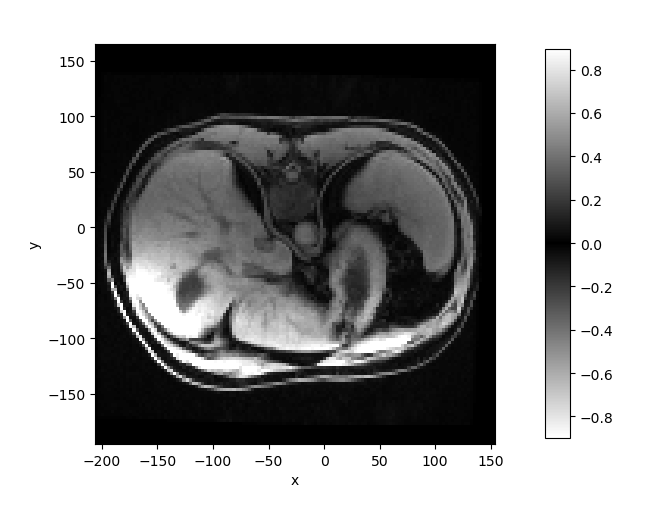

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [7]:
%autoreload
patient.view(compare=True)